In [1]:
## imported required packages
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from test_function import *

In [2]:
f = open("/storage/home/jkl5991/group/dbnsfp/tabix_try/tabixindex.txt")
header = f.readline().strip().split('\t')
f.close()

omit_model = pd.read_csv("/storage/home/jkl5991/work/project/not_conflict/all_model_new.tsv", sep = '\t')

omit = pd.read_csv('unannotated_omit_std.tsv', sep = '\t')
dominant = pd.read_csv('dominant_std.tsv', sep = '\t')
recessive = pd.read_csv("recessive_std.tsv",sep = '\t')


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# the features we used in our original study
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEAN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']

# the features for comparison (to other supervised score)
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score','MPC','primateAI','FATHMM_score', 'VEST4_score', 'LIST-S2_score']



allcolumn = original_column + features

In [4]:

# a function that create a "location" column for future combination
def createloc(df):
    df['location'] = df['chr'] + '-' + (df['pos']-1).map(str)+ '-' + df['pos'].map(str)+ '-' + df['ref'].map(str)+ '-' + df['alt'].map(str)
    df = df.drop(columns = ['chr', 'pos', 'ref', 'alt'])
    return(df)


def merge_with_original_df(originaldf, newdf):
    newdf = createloc(newdf)
    result = pd.merge(originaldf, newdf, on=['location'], how = 'inner')
    return(result)


In [5]:
### build de novo dataframe

def find_denovo_pattern_new(readfile, find_pattern):
    denovo_column = ['SampleID', 'StudyName', 'PubmedID', 'NumProbands', 'NumControls', 'SequenceType', 'PrimaryPhenotype', 
                 'Validation', 'Chr', 'Position', 'Variant', 'rsID', 'DbsnpBuild' , 'AncestralAllele', '1000GenomeCount', 
                 'ExacFreq', 'EspAaFreq', 'EspEaFreq', 'Transcript', 'condingDnaSize', 'Gene', 'FunctionClass', 'cDnaVariant', 'ProteinVariant', 
                 'Exon/Intron', 'PolyPhen(HDiv)', 'PolyPhen(Hvar)', 'SiftScore', 'CaddScore', 'LofScore', 'LrtScore' ]
    denovo = pd.read_csv(readfile, sep = '\t', header = None, names = denovo_column, comment = '#')
    
    
    # filtering only 'PrimaryPhenotype' = control and find_pattern 
    denovo = denovo[denovo['Variant'].str.len() == 3]
    denovo[np.logical_or(np.logical_and(denovo['PrimaryPhenotype'] == find_pattern, 
                                              denovo['FunctionClass'] == 'missense'),
                               denovo['PrimaryPhenotype'] == 'control')]
    denovo['origin'] = np.where(denovo['PrimaryPhenotype'] == find_pattern, 1,0)
    
    
    # only keep exon or whole genome sequencing data
    denovo = denovo[denovo['SequenceType'] != 'targeted']
    denovo = denovo[np.logical_or(denovo['PrimaryPhenotype'] == find_pattern, denovo['PrimaryPhenotype'] == 'control')]
    
     
    denovo['Variant'] = denovo['Variant'].str.replace('>', '-')
    denovo = denovo.assign(location = 'chr' + denovo['Chr'].astype(str) + '-' + (denovo['Position']-1).astype(str) +\
                     '-' + denovo['Position'].astype(str) +'-'+ denovo['Variant'])
    
    
    # remove all the unnecessary columns
    denovo = denovo.drop(['SampleID', 'StudyName', 'PubmedID', 'NumProbands', 'NumControls',  'Chr', 'Position',
                           'Variant', 'rsID', 'DbsnpBuild' , 'AncestralAllele', '1000GenomeCount', 'Exon/Intron',
                     'ExacFreq', 'EspAaFreq', 'EspEaFreq', 'Transcript', 'condingDnaSize', 'Gene', 'cDnaVariant', 'ProteinVariant', 
                     'PolyPhen(HDiv)', 'PolyPhen(Hvar)', 'SiftScore', 'CaddScore', 'LofScore', 'LrtScore'], axis=1)
    

    denovo = denovo.drop_duplicates()
    denovo_simple = denovo[['location','origin']].drop_duplicates()
    
    denovo_location = denovo['location'].drop_duplicates().to_frame()
    return(denovo, denovo_simple, denovo_location)
    

In [6]:
ssc = find_denovo_pattern_new('/storage/home/jkl5991/work/project/original_data/denovo-db.ssc-samples.variants.tsv.gz', 'autism')
#ssc[2].to_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/denovo_ssc_location.tsv', header = None, sep = '\t',index = False)

nonssc = find_denovo_pattern_new('/storage/home/jkl5991/work/project/original_data/denovo-db.non-ssc-samples.variants.tsv.gz', 'developmentalDisorder')
#nonssc[2].to_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/denovo_non_ssc_location.tsv', header = None, sep = '\t',index = False)


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
print(nonssc[1].shape)  #in nonssc dataset, ddd = 7357, control = 11309, total = 18666
print(np.sum(nonssc[1]['origin']))

nonssc[1][nonssc[1]['origin']==0]

(18666, 2)
7357


,location,origin
254,chr1-1545705-1545706-A-C,0
571,chr1-2921025-2921026-G-A,0
690,chr1-3457421-3457422-C-T,0
701,chr1-3529573-3529574-G-A,0
838,chr1-4420366-4420367-C-T,0
...,...,...
410659,chrX-78216310-78216311-C-T,0
412056,chrX-100183205-100183206-G-A,0
412387,chrX-106092515-106092516-T-C,0
414128,chrX-134078477-134078478-A-G,0


In [8]:
print(ssc[1].shape)  #in ssc dataset,autism = 68415 , control = 65909, total = 132324
print(np.sum(ssc[1]['origin']))

ssc[1][ssc[1]['origin']==0]

(134324, 2)
68415


,location,origin
2,chr1-14247-14248-T-G,0
7,chr1-18453-18454-G-C,0
8,chr1-18954-18955-A-G,0
9,chr1-19225-19226-T-A,0
10,chr1-20301-20302-G-A,0
...,...,...
212714,chrY-13640812-13640813-A-G,0
212715,chrY-24490730-24490731-T-G,0
212716,chrY-28549621-28549622-C-A,0
212717,chrY-28583522-28583523-C-T,0


In [ ]:
!cat denovo_non-ssc_location.tsv |tr '-' '\t' > non_ssc_loc.bed 
!sortBed -i non_ssc_loc.bed > non_ssc_sortedloc.bed

!cat denovo_ssc_location.tsv |tr '-' '\t' > ssc_loc.bed 
!sortBed -i ssc_loc.bed > ssc_sortedloc.bed 


!awk '{gsub("chr" , ""); print}' non_ssc_sortedloc.bed > non_ssc_loc4UNEECON.bed 
!awk '{gsub("chr" , ""); print}' denovo_location_sorted.bed > denovo_location_sorted4UNEECON.bed 


# in /storage/home/jkl5991/work/project/original_data
!tabix UNEECON_addchr.tsv.bgz -R ~/group/dbnsfp/tabix_try/ssc_sortedloc.bed > tabix_ssc_uneecon.tsv
!tabix UNEECON_addchr.tsv.bgz -R ~/group/dbnsfp/tabix_try/non_ssc_sortedloc.bed > tabix_non_ssc_uneecon.tsv

# in ~/group/dbnsfp/tabix_try
!tabix prediction_sorted.bed.bgz -R ssc_sortedloc.bed > tabix_ssc_original.tsv 
!tabix prediction_sorted.bed.bgz -R non_ssc_sortedloc.bed > tabix_non_ssc_original.tsv 
!tabix output2.bed.bgz -R ssc_sortedloc.bed > tabix_ssc_othermodel.tsv 
!tabix output2.bed.bgz -R non_ssc_sortedloc.bed > tabix_non_ssc_othermodel.tsv 


In [9]:
# import uneecon & original model
# nonssc

column =['chr', 'pos-1','pos', 'ref','alt','accession_num', 'SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEAN_pred',
               'SLR_score', 'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy',
               'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE', 'PredBFactorF', 'PredBFactorM', 'PredBFactorS',
               'PredStabilityH', 'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC', 'dscore',
               'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq'] 

nonssc_uneecon = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_non_ssc_uneecon.tsv', sep = '\t', names = ['chr','pos','ref','alt','UNEECON'])
nonssc_original = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_non_ssc_original.tsv', sep = '\t', names = column)
nonssc_othermodel = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_non_ssc_othermodel.tsv', sep = '\t', names = header)


ssc_uneecon = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_ssc_uneecon.tsv', sep = '\t', names = ['chr','pos','ref','alt','UNEECON'])
ssc_original = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_ssc_original.tsv', sep = '\t', names = column)
ssc_othermodel = pd.read_csv('/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_ssc_othermodel.tsv', sep = '\t', names = header)



In [83]:
ssc_original

,chr,pos-1,pos,ref,alt,accession_num,SIFT_pred,LRT_pred,MA_pred,PROVEAN_pred,...,PredStabilityM,PredStabilityL,PredSSE,PredSSH,PredSSC,dscore,phyloP_pri,phyloP_mam,phyloP_ver,RNA_seq
0,chr1,880106,880107,C,A,ENSG00000188976.6|NOC2L,1,0,1,0,...,-0.967601,1.443522,-1.323271,1.410250,0.570226,0.000004,-1.613777,-1.216713,-1.185513,0.955961
1,chr1,880106,880107,C,G,ENSG00000188976.6|NOC2L,1,0,1,0,...,-0.967601,1.443522,-1.323271,1.410250,0.570226,0.000004,-1.613777,-1.216713,-1.185513,0.955961
2,chr1,897348,897349,G,C,ENSG00000187961.9|KLHL17,0,1,0,0,...,-2.006744,1.966308,0.195216,-0.001938,-0.629464,0.232196,0.463953,-0.051947,-0.557575,-0.220031
3,chr1,897348,897349,G,T,ENSG00000187961.9|KLHL17,0,1,0,0,...,-2.006744,1.966308,0.195216,-0.001938,-0.629464,0.232196,0.463953,-0.051947,-0.557575,-0.220031
4,chr1,1141799,1141800,C,A,ENSG00000186891.9|TNFRSF18,1,0,0,0,...,-1.542840,1.728678,0.100823,0.023278,-0.389526,0.000004,0.238164,-0.292078,-0.963693,-0.843736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11730,chrX,153908481,153908482,G,A,ENSG00000160219.7|GAB3,1,0,0,0,...,0.377718,0.619738,-1.052406,1.248857,0.117009,0.000004,-3.447470,-1.536320,-0.988907,-0.168593
11731,chrX,153908481,153908482,G,C,ENSG00000160219.7|GAB3,1,0,0,0,...,0.377718,0.619738,-1.052406,1.248857,0.117009,0.000004,-3.447470,-1.536320,-0.988907,-0.168593
11732,chrX,153908481,153908482,G,T,ENSG00000160219.7|GAB3,0,0,0,0,...,0.377718,0.619738,-1.052406,1.248857,0.117009,0.000004,-3.447470,-1.536320,-0.988907,-0.168593
11733,chrX,153940861,153940862,G,C,ENSG00000160219.7|GAB3,0,0,1,0,...,1.249856,-0.477319,-0.264435,0.401543,-0.189578,0.000004,-1.974129,-1.255169,-0.994610,-0.306214


In [10]:
def denovo_process(original, uneecon, othermodel, df, semicol= ['LIST-S2_score', 'VEST4_score','MPC']):
    
    uneecon = createloc(uneecon)
    original = original.drop_duplicates()
    original = createloc(original)

    uneecon['location'] = 'chr' + uneecon['location']
    
    
    whole = pd.merge(original, uneecon , on = ['location'], how = 'inner')

    othermodel = createloc(othermodel)
    
    whole = pd.merge(whole, othermodel , on = ['location'], how = 'inner')
    
    ## FATHMM
    FATHMM_score =[]
    for i in whole['FATHMM_score'].str.split(';')[:]:
        i = list(filter(lambda a: a != '.', i))
        if len(i) == 0:
            FATHMM_score.append('.')
        else:
            FATHMM_score.append(float(min(i))*(-1))
    whole['FATHMM_score'] = np.array(FATHMM_score)
    
    whole = save_allsemicol(whole, semicol) 

    # remove all the rows that contain '.' (empty)
    whole = whole.drop(columns = ['pos-1_x','pos-1_y','accession_num','integrated_fitCons_score','H1-hESC_fitCons_score'])
    for i in features:
        whole.drop(whole.loc[whole[i] == '.'].index, inplace= True)
    
    denovo = pd.merge(whole, df, on = ['location'])
    
    print(denovo.shape)
    return(denovo, whole)


In [11]:
nonssc_denovo = denovo_process(nonssc_original, nonssc_uneecon, nonssc_othermodel, nonssc[1])[0]
ssc_denovo = denovo_process(ssc_original, ssc_uneecon, ssc_othermodel, ssc[1])[0]

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(3717, 44)
(2770, 44)


In [85]:
np.sum(nonssc_denovo['origin']) #4430 (there are only 145 control)

3600

In [97]:
nonssc_denovo[nonssc_denovo['origin']==1]

,SIFT_pred,LRT_pred,MA_pred,PROVEAN_pred,SLR_score,SIFT_score,LRT_omega,MA_score,PROVEAN_score,Grantham,...,MetaLR_score,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,MPC,primateAI,origin
0,1,0,1,1,0.005868,-0.567879,-0.025872,0.216339,0.136820,-0.492487,...,0.0816,0.03556,0.176,0.422896772623062,0.771423,17.26,0.993801,0.0108648878866,0.485019087791,1
1,0,0,0,0,0.607839,0.744453,-0.026173,-0.041929,0.461528,-0.773883,...,0.1956,0.172504,0.164,0.0278244740688326,0.777022,10.39,0.974786,0.141912031946,0.286668598652,1
2,1,0,0,0,1.751685,-0.588685,-0.001141,-0.002805,0.898633,2.191604,...,0.0447,0.003686,0.037,0.00739915213449482,0.462454,10.27,0.933396,0.025038035533,0.362148672342,1
3,1,0,0,1,-0.128979,-0.615438,-0.016728,-0.330838,-0.096303,0.221827,...,0.1640,0.146438,0.099,0.0350852094445877,0.656934,17.61,0.965139,0.322344995019,0.327294290066,1
4,0,0,0,0,-4.697541,0.539991,-0.025876,-2.160598,1.188252,-1.076926,...,0.0382,0.01356,0.037,0.047574416908975,0.887811,14.06,0.909101,0.0275081532542,0.496656030416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712,0,0,1,0,-2.653473,-0.296643,-0.024747,0.216339,0.415735,-0.773883,...,0.0833,0.029507,0.150,0.112774478397748,0.705629,21.00,0.997110,0.454903777487,0.319486618042,1
3713,1,1,1,1,0.005868,-0.593887,-0.028005,1.485790,-1.796157,1.650457,...,0.8996,0.965737,0.934,0.997914850711823,0.969603,31.00,0.998629,1.75615773249,0.89328122139,1
3714,0,1,1,1,0.005868,0.352092,-0.028005,0.566533,-0.328594,0.416641,...,0.7587,0.125787,0.420,0.826556205749512,0.835616,20.20,0.843118,0.538348067403,0.631224751472,1
3715,1,0,1,1,-0.195457,-0.587199,-0.028005,1.122464,-0.316242,-0.730592,...,0.3964,0.455283,0.443,0.979071021080017,0.866813,22.70,0.996679,2.62646606766,0.897083342075,1


In [25]:
# nonssc[1][~nonssc[1]['location'].isin(nonssc_whole['location'])]

# #np.sum(nonssc[1][~nonssc[1]['location'].isin(nonssc_whole['location'])]['result'])   
# # denovo data that are not in nonssc_whole = 14198, with 3032 proband

In [13]:
ssc_control = ssc_denovo[ssc_denovo['origin']==0]

In [15]:
#ssc_whole = pd.merge(ssc_original, ssc_uneecon , on = ['location'], how = 'inner')
#nonssc_denovo.append(pd.merge(ssc_denovo, ssc[0][ssc[0]['origin'] ==0] , on = ['location'], how = 'inner'))['FunctionClass'].value_counts()

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


missense                       1172
intron                           78
non-coding-exon                  66
missense-near-splice             31
5-prime-UTR                      12
3-prime-UTR                      10
non-coding-exon-near-splice       3
synonymous                        2
synonymous-near-splice            1
Name: FunctionClass, dtype: int64

In [14]:
denovo = nonssc_denovo.append(ssc_control) #4229,44

In [15]:
denovo

,SIFT_pred,LRT_pred,MA_pred,PROVEAN_pred,SLR_score,SIFT_score,LRT_omega,MA_score,PROVEAN_score,Grantham,...,MetaLR_score,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,MPC,primateAI,origin
0,1,0,1,1,0.005868,-0.567879,-0.025872,0.216339,0.136820,-0.492487,...,0.0816,0.03556,0.176,0.422896772623062,0.771423,17.26,0.993801,0.0108648878866,0.485019087791,1
1,0,0,0,0,0.607839,0.744453,-0.026173,-0.041929,0.461528,-0.773883,...,0.1956,0.172504,0.164,0.0278244740688326,0.777022,10.39,0.974786,0.141912031946,0.286668598652,1
2,1,0,0,0,1.751685,-0.588685,-0.001141,-0.002805,0.898633,2.191604,...,0.0447,0.003686,0.037,0.00739915213449482,0.462454,10.27,0.933396,0.025038035533,0.362148672342,1
3,1,0,0,1,-0.128979,-0.615438,-0.016728,-0.330838,-0.096303,0.221827,...,0.1640,0.146438,0.099,0.0350852094445877,0.656934,17.61,0.965139,0.322344995019,0.327294290066,1
4,0,0,0,0,-4.697541,0.539991,-0.025876,-2.160598,1.188252,-1.076926,...,0.0382,0.01356,0.037,0.047574416908975,0.887811,14.06,0.909101,0.0275081532542,0.496656030416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,1,0,0,0,1.042752,-0.449129,0.002114,0.036865,0.463191,-0.492487,...,0.1343,0.020687,0.100,0.780053770233618,0.863714,22.50,0.998778,0.246864595568,0.376200139523,0
2764,0,1,0,0,-1.707224,0.030325,-0.028005,-1.972370,0.116006,-1.011988,...,0.6922,0.293518,0.623,0.934659779071808,0.985301,22.50,0.997626,1.53347345661,0.844758212566,0
2765,1,0,1,1,0.005868,-0.624354,-0.028005,0.868574,-1.730660,0.481578,...,0.3319,0.101583,0.363,0.992260992527008,0.960404,32.00,0.999141,1.40577105904,0.674640893936,0
2766,1,0,1,1,0.478370,-0.605629,-0.024589,0.203206,-0.321099,-0.492487,...,0.1080,0.136988,0.272,0.737025082111359,0.964504,21.80,0.997202,1.28113235318,0.501935362816,0


In [104]:
denovo.columns

Index(['SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEAN_pred', 'SLR_score',
       'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEAN_score', 'Grantham',
       'HMMEntropy', 'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE',
       'PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH',
       'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC',
       'dscore', 'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq',
       'location', 'UNEECON', 'FATHMM_score', 'VEST4_score', 'MetaSVM_score',
       'MetaLR_score', 'M-CAP_score', 'REVEL_score', 'ClinPred_score',
       'LIST-S2_score', 'CADD_phred_hg19', 'DANN_score', 'MPC', 'primateAI',
       'origin'],
      dtype='object')

In [92]:
len(nonssc_denovo.columns)

44

In [18]:
from sklearn.metrics.cluster import contingency_matrix
oddsratio, pvalue = stats.fisher_exact(contingency_matrix([0,0,1,1],[0,0,1,0]))

In [26]:
import statsmodels.api as sm

sm.stats.Table2x2(np.asarray([[505, 93], [3835, 1552]])).summary()  #type = statsmodels.iolib.table.SimpleTable

,Estimate,SE,LCB,UCB,p-value
Odds ratio,2.198,,1.748,2.763,0.000
Log odds ratio,0.787,0.117,0.558,1.016,0.000
Risk ratio,1.186,,1.142,1.233,0.000
Log risk ratio,0.171,0.020,0.132,0.209,0.000


In [49]:
def split(df, Xname, Yname, testsize = 0.1):
    y = df.loc[:,[Yname]].values
    y = y.flatten()
    X = df.loc[:,Xname]
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest)

def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, fitmodel = False):
    if(fitmodel == False):
        model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
        model.fit(Xtrain, ytrain)
    else:
        model = fitmodel
    
    model_pred = model.decision_function(Xtest)
    
    return(ytest, model_pred, model)


Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = split(omit, original_column, 'clinvar_result')
Xtrain_domi, Xvalid_domi, Xtest_domi, ytrain_domi, yvalid_domi, ytest_domi = split(dominant, original_column, 'clinvar_result')


X_test = denovo.loc[:,original_column]
y_test = denovo.loc[:,['origin']].values

denovo_gb = fitting_gb(Xtrain, ytrain, X_test, y_test, 0.1, 3, 150)
denovo_gb_domi = fitting_gb(Xtrain_domi, ytrain_domi, X_test, y_test, 0.1, 3, 150)

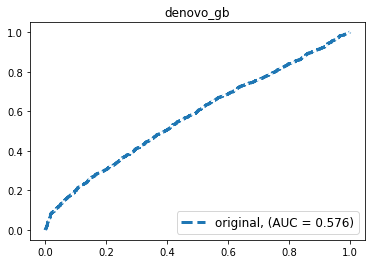

In [18]:
#drawROC(denovo_gb_domi[0], denovo_gomi[1], label = 'original_dominant')
drawROC(denovo_gb[0], denovo_gb[1], label = 'original',lastone = True,title = "denovo_gb")

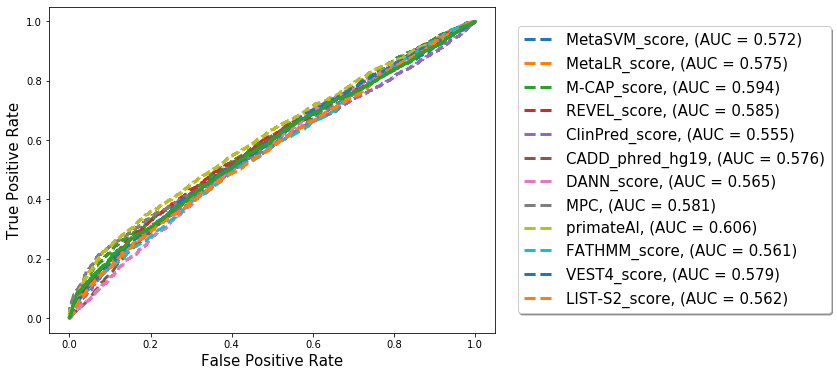

In [48]:
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'False Positive Rate', y = 'True Positive Rate', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (auROC=%0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x,fontsize = 15)
        ax.set_ylabel(y, fontsize = 15)
        ax.set_title(title, fontsize = 15)
        #ax.legend(loc='lower right',fontsize = 14)

plt.rcParams['figure.figsize'] = [8,6]
fig, ax = plt.subplots(1, 1)

for i in features:
    drawROC(denovo['origin'], denovo[i].values.astype(float), label = i)
ax.legend(loc='center', bbox_to_anchor= (1.4,0.5),fancybox=True, shadow=True,fontsize = 15)
get_ROC(ax,denovo_gb[0], denovo_gb[1], label = 'our_model',lastone = True,lw=3, linestyle = '-')
plt.savefig('figure/6_denovo.pdf',bbox_inches = "tight")

In [50]:
denovo['our_model'] = denovo_gb[1]
denovo['our_model_domi'] = denovo_gb_domi[1]
features.append('our_model')
features.append('our_model_domi')

In [53]:
features.append('UNEECON')

In [51]:
#enrichment
def enrichment(df, portion, features, name,log = True):
    # how much enrichment you want to test
    num = int(df.shape[0]*portion*0.01)

    oddsratios = []
    errors = []
    for i in features:
        
        df[i] = pd.to_numeric(df[i])
        top = np.sum(df.nlargest(num,i)['origin']) 
        array1 = [top, num-top]
        #print(matrix1)
    
        #matrix = contingency_table([1]*num, df.nlargest(num,i)['result'], num)
        #matrix = confusion_matrix(abs(df.nlargest(num,i)['result']-1),[0]*num)
              
        tail = np.sum(df.nsmallest(df.shape[0]-num,i)['origin'])
        array2 = [tail, df.shape[0]-num-tail]
        #print(array2)
        #print(np.asarray([array1, array2]))
        
        result = sm.stats.Table2x2(np.asarray([array1, array2])).oddsratio
    
        if(log == True):
            result = math.log2(result)
            #result = math.log(result)
        #print(result)
        oddsratios.append(result)

        # check
        #print((top/(num-top))/(tail/(df.shape[0]-num-tail)))
        

        # change of base
        error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))* math.log2(math.e)
        #error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))
        errors.append(error)
     
    # Build the plot
    fig, sub = plt.subplots(figsize=(15, 7))
    
    sub.bar(features, oddsratios,yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=5)

    
    plt.title("enrichment threshold: %s percent"%portion,size = 15)
    #plt.xticks(rotation=35,labelsize=15)
    plt.tick_params(axis='x', labelsize=15, rotation = 30)
    plt.ylabel("log2 enrichment",size = 15) 
    plt.tight_layout()
    plt.savefig(name)
    plt.show() 
 #   return(oddsratios, np.asarray([array1,array2]))    


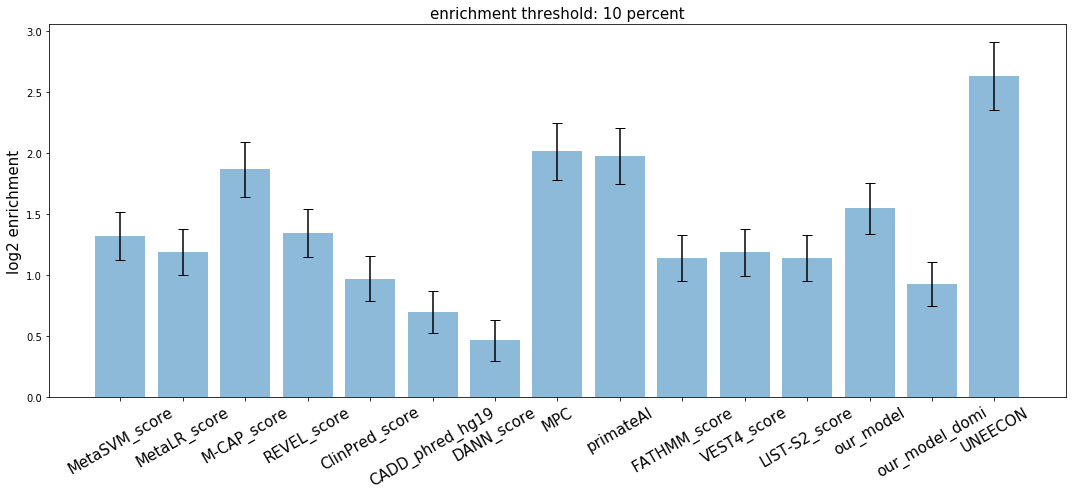

In [55]:
enrichment(denovo, 10, features, 'figure/6_enrichment10_wdomi.pdf') #2 as base

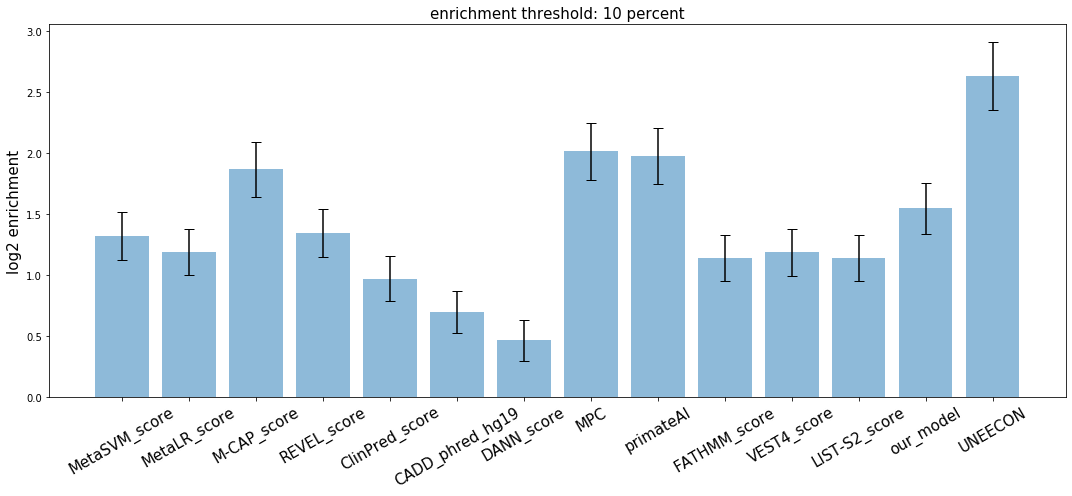

In [126]:
enrichment(denovo, 10, features, 'figure/6_enrichment10.pdf') #2 as base

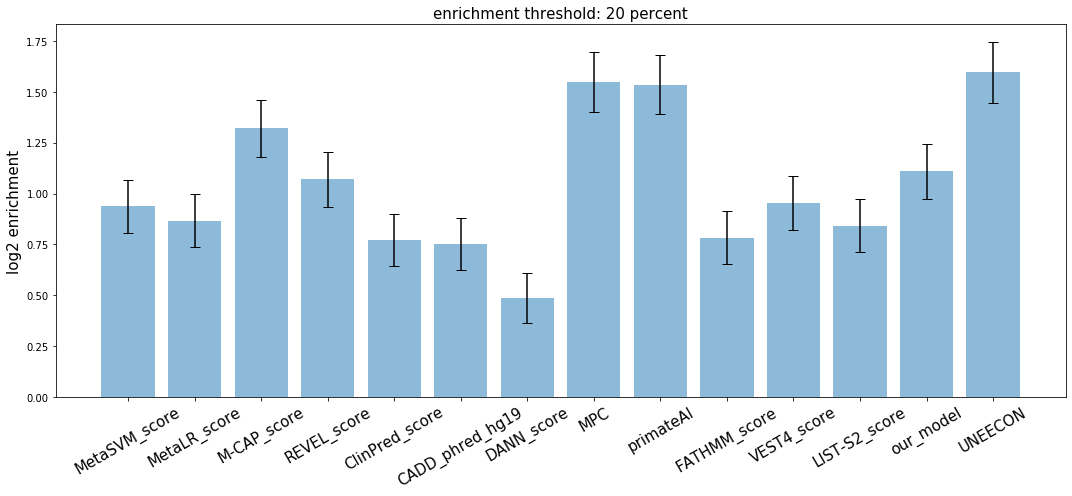

In [127]:
enrichment(denovo, 20, features, 'figure/6_enrichment20.pdf') #2 as base

In [64]:
#check the performance with no_assertion_criteria_provided data removed

# omit_with_criteria = pd.read_csv('omit_with_criteria.tsv', sep = '\t')

# omit_with_criteria = omit_with_criteria.rename(columns = {'PROVEN_score':'PROVEAN_score', 'PROVEN_pred':'PROVEAN_pred'})
# X_train, X_valid, X_test, y_train, y_valid, y_test = split(omit_with_criteria, original_column, 'clinvar_result')


In [65]:
omit_with_criteria

,location,accession_num,clinvar_result,SIFT_pred,LRT_pred,MA_pred,PROVEAN_pred,SLR_score,SIFT_score,LRT_omega,...,PredStabilityL,PredSSE,PredSSH,PredSSC,dscore,phyloP_pri,phyloP_mam,phyloP_ver,RNA_seq,UNEECON
0,chr22-38165338-38165339-A-G,ENSG00000100106.15|TRIOBP,0,0,0,0,0,0.017887,0.326375,0.000248,...,1.039047,-1.325180,1.081073,1.489858,-1.825663,0.163180,-1.015673,-0.863177,0.839322,-0.877817
1,chr9-113562608-113562609-A-C,ENSG00000030304.8|MUSK,0,0,1,0,0,0.017887,0.202738,-0.028677,...,-1.301443,0.782341,-0.715683,-0.650789,-1.128772,0.290193,0.546426,0.612994,-0.441018,-0.687471
2,chr17-44108989-44108990-T-C,ENSG00000120071.8|KANSL1,0,0,0,0,0,0.433918,0.030332,-0.027496,...,1.836758,-1.421342,1.256843,1.326242,-0.024069,0.298661,0.603737,-0.110707,0.059049,-0.757529
3,chr1-66081790-66081791-C-T,ENSG00000116678.14|LEPR,0,1,1,1,1,-0.374086,-0.609563,-0.027606,...,-0.977500,0.229417,-0.095607,-0.514441,1.844720,0.630588,0.862373,0.421832,0.634567,1.221792
4,chr15-56125236-56125237-C-T,ENSG00000069869.11|NEDD4,0,0,0,0,0,0.017887,-0.044625,0.000248,...,1.010703,0.698201,-0.642445,-0.596248,-0.024069,-1.281384,-2.222149,-1.601262,0.286345,-0.882107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48909,chrX-154490226-154490227-G-T,ENSG00000155961.4|RAB39B,1,1,1,1,1,0.017887,-0.611212,-0.028677,...,-1.495809,1.331260,-1.374819,-0.691691,-0.024069,0.390110,0.732320,1.538919,-1.007271,2.065547
48910,chrX-154493571-154493572-A-G,ENSG00000155961.4|RAB39B,1,1,0,0,0,0.017887,-0.602968,-0.026964,...,1.209118,-1.717837,0.739299,3.780487,-0.024069,0.344386,0.364940,0.551025,-1.032165,1.004277
48911,chrY-2655264-2655265-T-C,ENSG00000184895.6|SRY,1,1,0,1,1,0.017887,-0.619453,0.000248,...,-1.030140,-1.148886,1.208018,0.549066,-0.024069,-0.385517,-0.549836,0.416853,-1.121325,-0.189684
48912,chrY-2655417-2655418-C-A,ENSG00000184895.6|SRY,1,1,0,1,1,0.017887,-0.619453,0.000248,...,1.780067,-0.736197,1.012719,-0.323554,-0.024069,-0.370275,-1.167034,-0.051228,-1.379246,-0.347274


In [27]:
pred_w_assertion = fitting_gb(X_train, y_train, denovo.loc[:,original_column], denovo.loc[:,['result']].values,0.15,5,150)


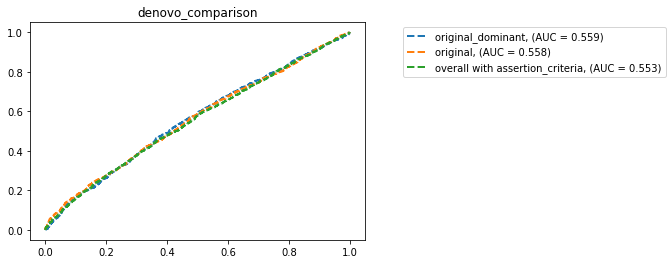

In [28]:
drawROC(denovo_gb_domi[0], denovo_gb_domi[1], label = 'original_dominant')
drawROC(denovo_gb[0], denovo_gb[1], label = 'original')
drawROC(pred_w_assertion[0], pred_w_assertion[1], label = 'overall with assertion_criteria', lastone = True, title = "denovo_comparison")

In [29]:
# save for future use
allmodel = pd.read_csv('all_model_new.tsv',sep = '\t')
allmodel.drop(columns = ['location', 'accession_num'])

allmodel['source'] = 0 # original
denovo['source'] = 1 # denovo
allmodel['result'] = allmodel['clinvar_result']

In [30]:
full = pd.concat([allmodel, denovo], join='inner')
#full.to_csv('allmodel_denovo.csv', sep = '\t',index = False)

In [31]:
#denovo.to_csv('denovo_data.csv', sep = '\t', index = False)

In [21]:
denovo = pd.read_csv('denovo_data.csv', sep = '\t')

In [22]:
original_column

['SIFT_pred',
 'LRT_pred',
 'MA_pred',
 'PROVEN_pred',
 'SLR_score',
 'SIFT_score',
 'LRT_omega',
 'MA_score',
 'PROVEN_score',
 'Grantham',
 'HMMEntropy',
 'HMMRelEntropy',
 'PredRSAB',
 'PredRSAI',
 'PredRSAE',
 'PredBFactorF',
 'PredBFactorM',
 'PredBFactorS',
 'PredStabilityH',
 'PredStabilityM',
 'PredStabilityL',
 'PredSSE',
 'PredSSH',
 'PredSSC',
 'dscore',
 'phyloP_pri',
 'phyloP_mam',
 'phyloP_ver',
 'RNA_seq',
 'UNEECON']

In [ ]:
def splitNfit(dataframe, Xname, Yname, regression = 0,testsize = 0.3, regulation = False):
    y = dataframe.loc[:,[Yname]].values
    y = y.flatten()
    X = dataframe.loc[:,Xname]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = testsize, random_state = 42)
   
    if regression == 0:
        if regulation == False :
            regression = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(X_train, y_train)
        else:
            regression = LogisticRegression(random_state = 42 , penalty = regulation).fit(X_train, y_train)
    test_hat = regression.predict_proba(X_test)[:,1]
    return(X_train, X_test, y_train, y_test, test_hat, regression)




In [26]:
X_train_de, X_test_de, y_train_de, y_test_de, test_hat_de, regression = splitNfit(denovo, original_column, 'result' )

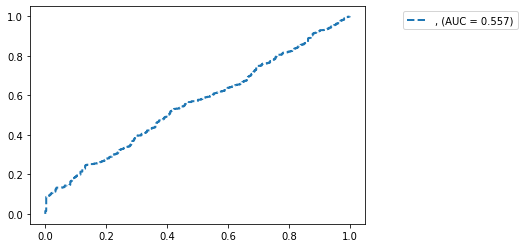

In [29]:
drawROC(y_test_de, test_hat_de,lastone = True)

In [43]:
features.append('denovo')
features.append('UNEECON')

In [35]:
denovo

,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,MA_score,PROVEN_score,Grantham,...,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,MPC,primateAI,result,our_model,source
0,1,0,1,1,0.005868,-0.567879,-0.025872,0.216339,0.136820,-0.492487,...,0.176,0.422897,0.771423,17.26,0.993801,0.010865,0.485019,1,-1.116537,1
1,1,0,0,0,1.751685,-0.588685,-0.001141,-0.002805,0.898633,2.191604,...,0.037,0.007399,0.462454,10.27,0.933396,0.025038,0.362149,1,-2.254470,1
2,1,0,0,1,-0.128979,-0.615438,-0.016728,-0.330838,-0.096303,0.221827,...,0.099,0.035085,0.656934,17.61,0.965139,0.322345,0.327294,1,0.103309,1
3,0,0,0,0,-4.697541,0.539991,-0.025876,-2.160598,1.188252,-1.076926,...,0.037,0.047574,0.887811,14.06,0.909101,0.027508,0.496656,1,-2.149526,1
4,1,0,0,1,0.005868,-0.503971,-0.025176,-0.090080,0.069174,2.191604,...,0.107,0.110794,0.792121,24.60,0.993957,0.112563,0.802351,1,-0.970616,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,1,0,0,0,1.042752,-0.449129,0.002114,0.036865,0.463191,-0.492487,...,0.100,0.780054,0.863714,22.50,0.998778,0.246865,0.376200,0,-2.185668,1
4225,0,1,0,0,-1.707224,0.030325,-0.028005,-1.972370,0.116006,-1.011988,...,0.623,0.934660,0.985301,22.50,0.997626,1.533473,0.844758,0,0.130089,1
4226,1,0,1,1,0.005868,-0.624354,-0.028005,0.868574,-1.730660,0.481578,...,0.363,0.992261,0.960404,32.00,0.999141,1.405771,0.674641,0,1.896889,1
4227,1,0,1,1,0.478370,-0.605629,-0.024589,0.203206,-0.321099,-0.492487,...,0.272,0.737025,0.964504,21.80,0.997202,1.281132,0.501935,0,0.806817,1


In [41]:
X_test_de

,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,MA_score,PROVEN_score,Grantham,...,PredSSH,PredSSC,dscore,phyloP_pri,phyloP_mam,phyloP_ver,RNA_seq,UNEECON,result,denovo
1736,1,1,1,0,0.286889,-0.619897,-0.027679,0.273246,0.282521,-0.492487,...,1.314422,-0.109599,-0.711015,0.272374,0.548810,1.676225,1.481996,0.803190,1,0.827835
4021,1,0,0,0,1.469867,-0.609196,-0.026521,-0.873639,0.386594,1.022726,...,0.981550,1.449998,-0.087769,0.231321,-0.255332,-0.451318,0.842861,0.017197,0,0.687202
2390,1,1,1,1,0.005868,-0.619897,-0.027526,1.779077,-1.719004,0.481578,...,0.825200,-0.282888,0.000004,0.463953,-0.069892,0.624160,0.086944,0.238867,1,0.724121
908,1,1,1,1,0.005868,-0.618622,-0.028005,0.452720,-0.227732,-0.622362,...,-1.711696,-0.709444,1.727381,0.666938,1.264933,0.900308,-0.525435,0.095459,1,0.675186
1344,1,0,0,1,0.005868,-0.453651,-0.025196,-0.133854,-0.152800,-0.492487,...,1.026941,0.863483,0.000004,0.454831,-1.090238,-1.011419,-0.379732,0.099353,1,0.696750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,1,0,0,0,1.457643,1.004543,-0.022023,-0.873639,0.877819,0.654745,...,1.037028,-0.242898,-2.338129,-2.152025,-0.610830,-1.016823,-0.608276,0.099641,1,0.664365
841,1,1,0,0,-0.343972,-0.461614,-0.028005,-0.090080,0.484423,0.676391,...,-1.863002,-0.722773,0.309532,0.678340,0.101875,-0.708557,-0.604491,0.155213,1,0.726310
3475,1,1,1,1,-0.809742,-0.561934,-0.028005,1.582093,-0.937211,-0.405903,...,0.764678,-0.162918,0.000004,0.678340,1.071803,1.203771,0.452817,0.658794,0,0.809247
2585,1,0,1,0,0.005868,-0.613208,-0.025224,0.443965,0.165960,-0.773883,...,-0.269246,-0.496165,0.533962,0.249567,0.639394,1.508135,0.381318,0.831340,1,0.843559


In [40]:
X_test_de['result'] = y_test_de
X_test_de['denovo'] = test_hat_de

In [55]:
featuresz

['MetaSVM_score',
 'MetaLR_score',
 'M-CAP_score',
 'REVEL_score',
 'ClinPred_score',
 'CADD_phred_hg19',
 'DANN_score',
 'MPC',
 'primateAI',
 'FATHMM_score',
 'VEST4_score',
 'LIST-S2_score',
 'UNEECON',
 'denovo']

In [57]:
enrichment(X_test_de,10, features)

KeyError: 'MetaSVM_score'

In [48]:
int(X_test_de.shape[0]*0.1)

126

In [ ]:
def enrichment(df, portion, features, log = True):
    #num = int(df.shape[0]*portion*0.01)
    num = 126
    oddsratios = []
    errors = []
    for i in features:
        
        df[i] = pd.to_numeric(df[i])
        top = np.sum(df.nlargest(num,i)['result']) 
        array1 = [top, num-top]
        #print(matrix1)
    
        #matrix = contingency_table([1]*num, df.nlargest(num,i)['result'], num)
        #matrix = confusion_matrix(abs(df.nlargest(num,i)['result']-1),[0]*num)
              
        tail = np.sum(df.nsmallest(df.shape[0]-num,i)['result'])
        array2 = [tail, df.shape[0]-num-tail]
        #print(array2)
        #print(np.asarray([array1, array2]))
        
        result = sm.stats.Table2x2(np.asarray([array1, array2])).oddsratio
    
        if(log == True):
            result = math.log2(result)
            #result = math.log(result)
        #print(result)
        oddsratios.append(result)

        # check
        #print((top/(num-top))/(tail/(df.shape[0]-num-tail)))
        

        # change of base
        error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))* math.log2(math.e)
        #error = math.sqrt(1/top + 1/(num-top) + 1/tail + 1/(df.shape[0]-num-tail))
        errors.append(error)
     
    # Build the plot
    fig, sub = plt.subplots(figsize=(15, 7))
    
    sub.bar(features, oddsratios,yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=5)
   
    plt.ylabel("log2 enrichment of proband denovo data")
    
    plt.title("enrichment test, enrichment level = %s percent"%portion)
    plt.xticks(rotation=35)
    plt.ylabel("log2 enrichment") 
    
    plt.show() 
 #   return(oddsratios, np.asarray([array1,array2]))    
